# Week 1 - Tasks

- **Data Source:** `yfinance`
- **Assets:** `AAPL`, `MSFT`, `GOOG`, `AMZN`, `TSLA` (and `NVDA` for Task 5)
- **Timeframes:**
  * **Long Term:** `start="2015-01-01", end="2024-01-01"`
  * **Medium Term:** `start="2020-01-01", end="2024-01-01"` (Includes COVID crash)

The goal for this week is to gain familiarity with financial data, analyze common trends, learn standard library functions, and touch upon the underlying theory.

## Task 1 - Setup
* Fetch **Long Term** historical data for the 5 assets.
* Extract the `Adjusted Close` values.
    * *Note: Check for missing values or empty rows and handle them (drop or fill).*
* Use `df.describe()` to extract key summary statistics.
* Extract the **Medium Term** data as well for later tasks.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats

In [2]:
assets = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']
long_term_start = "2015-01-01"
long_term_end = "2024-01-01"
medium_term_start = "2020-01-01"
medium_term_end = "2024-01-01"

In [6]:
long_term_data = yf.download(assets, start=long_term_start, end=long_term_end, auto_adjust=False)['Adj Close']

long_term_data = long_term_data.ffill().bfill()

print("Long Term Data:")
print(long_term_data.describe())

[*********************100%***********************]  5 of 5 completed

Long Term Data:
Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   2264.000000  2264.000000  2264.000000  2264.000000  2264.000000
mean      81.394710    91.950540    73.063479   154.516907   102.886245
std       55.990879    48.654536    36.298158    99.658478   110.936400
min       20.604074    14.347500    24.377237    34.437160     9.578000
25%       32.814689    44.303625    41.515255    59.182487    16.670500
50%       51.220848    90.691998    59.376663   127.528820    23.160666
75%      139.017624   133.230000   104.133991   244.037369   214.290005
max      196.256577   186.570496   149.587082   377.077820   409.970001


In [7]:
medium_term_data = yf.download(assets, start=medium_term_start, end=medium_term_end, auto_adjust=False)['Adj Close']

medium_term_data = medium_term_data.ffill().bfill()

print("Medium Term Data:")
print(medium_term_data.describe())

[*********************100%***********************]  5 of 5 completed

Medium Term Data:
Ticker         AAPL         AMZN         GOOG         MSFT         TSLA
count   1006.000000  1006.000000  1006.000000  1006.000000  1006.000000
mean     138.087082   137.216247   107.730847   254.761907   209.126371
std       33.389043    27.468805    25.245550    54.935813    85.797682
min       54.264339    81.820000    52.437710   128.929962    24.081333
25%      120.509689   114.309002    87.621819   213.318680   160.210003
50%      142.950027   140.585007   109.824059   251.500122   223.489998
75%      163.347755   161.190620   130.478874   294.432343   262.967491
max      196.256577   186.570496   149.587051   377.077789   409.970001


## Task 2 - Basic Trends
* Select **one asset** and using the **Medium Term** data, compute:
    * **Returns:** 1-day, 5-day, and 20-day simple returns.
    * **Log Returns:** 1-day, 5-day, and 20-day log returns.
    * **Volatility:** 5-day, 20-day, and 60-day rolling standard deviation (volatility) of the log returns.
* **Plotting:**
    * Plot the price and the 20-day moving average on one chart.
    * Plot the 1-day log returns on a separate chart.
    * Plot the rolling volatilities on a third chart.
    * *Analysis:* What trends do you observe? Does high volatility correlate with price drops?

* **Bonus (Long Term Data):**
    * Create a scatter plot of `|Daily Return|` vs `Volume`. Is there a relationship?
    * Group returns and volatility by **Month** (e.g., all Januaries, all Februaries) and plot the averages. Is there a "seasonal" effect?

In [28]:
asset = 'AAPL'
apple_data = medium_term_data[[asset]].copy()
apple_data

Ticker,AAPL
Date,
2020-01-02,72.468262
2020-01-03,71.763725
2020-01-06,72.335564
2020-01-07,71.995354
2020-01-08,73.153511
...,...
2023-12-22,191.788757
2023-12-26,191.243912
2023-12-27,191.342972


In [37]:
ret_arr = [1, 5, 20]

for n in ret_arr:
    apple_data[f'{n}-day return'] = apple_data[asset].diff(periods=n)
    apple_data[f'{n}-day log return'] = np.log(apple_data[asset]).diff(periods=n)

for n in [5, 20, 60]:
    apple_data[f'{n}-day volatility'] = apple_data['1-day log return'].rolling(n).std()

apple_data['Moving Avg'] = apple_data[asset].rolling(window=20).mean()

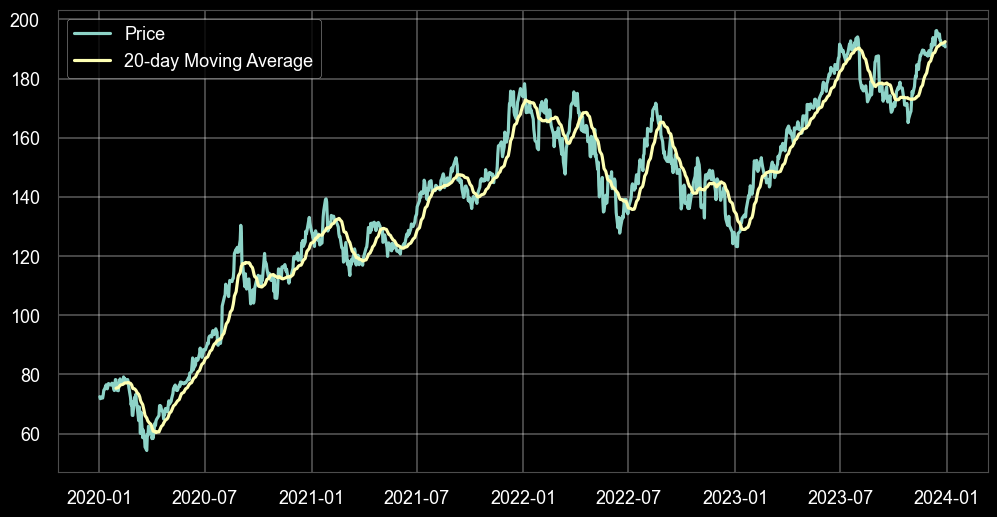

In [38]:
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8

fig, ax = plt.subplots(figsize=(12, 6))

# Plot both lines on the same axes
ax.plot(apple_data.index, apple_data[asset], label='Price')
ax.plot(apple_data.index, apple_data['Moving Avg'], label='20-day Moving Average')
ax.legend()

Text(0, 0.5, 'Log Return')

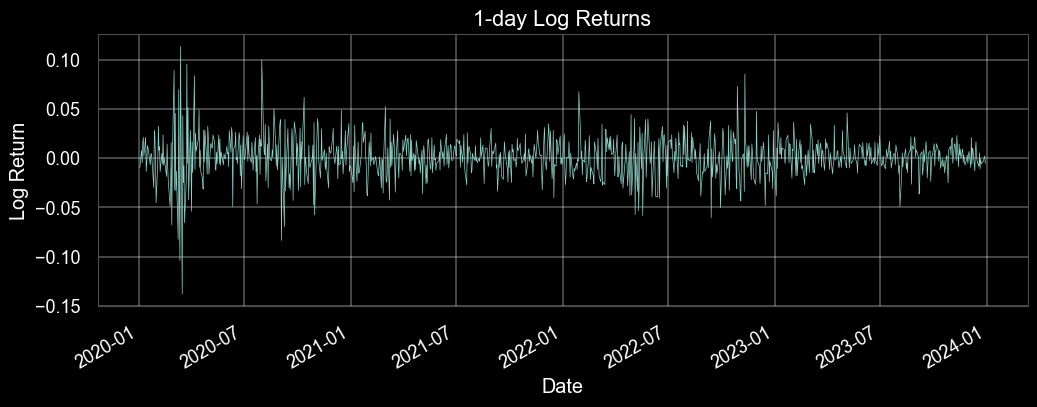

In [41]:
apple_data['1-day log return'].dropna().plot(title="1-day Log Returns", linewidth=0.5)
plt.ylabel("Log Return")

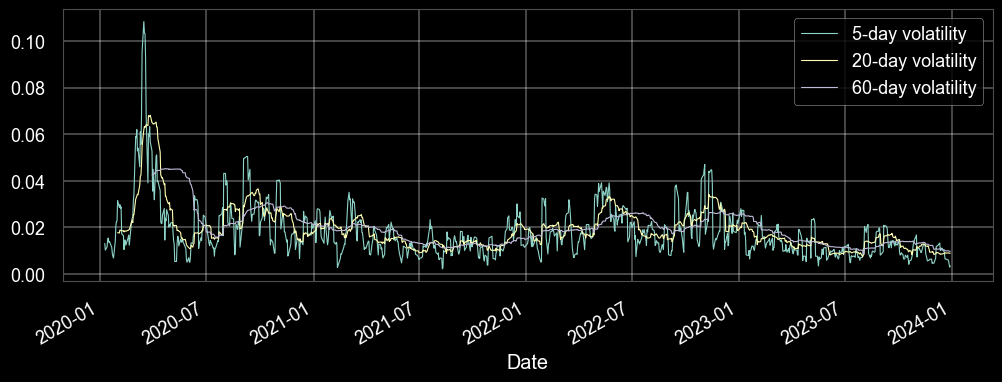

In [45]:
for n in [5, 20, 60]:
    apple_data[f'{n}-day volatility'].dropna().plot(linewidth=0.8)

plt.legend()

## Task 3 - Stationarity
* Select **one asset** (Long Term).
* Compute the **Rolling Mean** and **Rolling Standard Deviation** of log returns with window sizes `20, 60, 120`.
* Plot them and visually inspect.
    * Does the mean stay constant? (Stationary mean)
    * Does the variance stay constant? (Stationary variance)
* Run an **Augmented Dickey-Fuller (ADF) Test** on the log return series.
    * Library: `from statsmodels.tsa.stattools import adfuller`
    * *Goal:* Interpret the p-value. The Null Hypothesis ($H_0$) is that the series is non-stationary (has a unit root). If p-value < 0.05, we reject $H_0$.
    * For learning about hypothesis testing and p-value you can refer to CS215 slides or other standard resources mentioned in READMEs.

In [46]:
asset = "GOOG"
google_data = long_term_data[[asset]].copy()
google_data

Ticker,GOOG
Date,
2015-01-02,25.973848
2015-01-05,25.432405
2015-01-06,24.842955
2015-01-07,24.800392
2015-01-08,24.878592
...,...
2023-12-22,141.657547
2023-12-26,141.756790
2023-12-27,140.387085


## Task 4 - Volatility Regimes
We try to study the trend in volatility more deeply. From the ACF/PACF plot we know that volatility tends to cluster that is the market is either in a high volatility state (greater daily fluctuations) or low volatility state (stable prices, quiet markets).

Formally we can treat volatility as a *conditional standard deviation of returns*, conditioned on the history observed so far. We *cannot* predict *true* volatility for a given day based on the single return value, hence we try to estimate it using the past information. For this we look at two indicators of volatility:

1.  **Rolling Window Volatility:** Simple Moving Average (SMA) of standard deviation.
2.  **EWMA Volatility:** Exponentially Weighted Moving Average. This gives more weight to recent events. It is given by $\sigma_t^2 = (1-\lambda)r_t^2 + \lambda \sigma_{t-1}^2$.

**Steps:**
* Pick an asset and use data covering the **Feb-Mar 2020 COVID crash**.
* Compute two volatility estimates on the Log Returns:
    1.  **Rolling 20-day Volatility:** Standard deviation over a 20-day window.
    2.  **EWMA Volatility (RiskMetrics):** Use a decay factor $\lambda = 0.94$.
        * *Hint:* In pandas `df.ewm()`, the parameter `alpha` corresponds to $1 - \lambda$. So, use `alpha=0.06`.
* **Analysis:**
    * Plot both estimates on the same chart.
    * Which is smoother?
    * Which estimator reacts faster to the sudden crash in March 2020?
    * Which one would you prefer for risk management?
* **Regime Detection:** Compute the 60th percentile of your EWMA volatility series. Shade the regions on the plot where volatility exceeds this level.

* **Bonus:** A good volatility model "standardizes" the returns well. Calculate $z_t = r_t / \hat{\sigma}_t$. If the model is good, $z_t$ should have $Var \approx 1$. Check the variance of $z_t$ and plot its histogram.

## Task 5 - Time Horizons and the "Normal" Illusion
Short-term markets are noisy and dangerous (fat tails), while long-term data looks smoother. We can prove this statistically using **Skew** and **Kurtosis**.

**Theory:**
* **Skewness:** Measures asymmetry. (Negative skew = frequent small gains, few extreme losses).
* **Kurtosis:** Measures "tailedness". (High kurtosis = frequent extreme events/crashes).
* **Normal Distribution:** Skew $\approx 0$, Kurtosis $\approx 3$ (or Excess Kurtosis $\approx 0$).

**Steps:**
1.  Take your **Long Term** data for one asset (e.g., NVDA or TSLA).
2.  Resample the prices to get **Weekly** and **Monthly** closes.
    * Use `df['Adj Close'].resample('W').last()` and `...resample('M').last()`.
3.  Compute Log Returns for all three series: Daily, Weekly, Monthly.
4.  **The Test:**
    * Calculate **Skew** and **Kurtosis** for each of the three return series.
    * *Question:* How do these values change as the time horizon increases? Do they get closer to 0 and 3?
5.  **Visualization:**
    * Plot the **Histograms** of the Daily returns vs. Monthly returns on the same plot.
    * *Tip:* You will need to standardize them (subtract mean, divide by std dev) to overlay them meaningfully.
    * *Observation:* Look at the tails. Which one has "fatter" tails (more extreme outliers)?

**Key Takeaway:**
Daily returns often violate the "Normal Distribution" assumption used in many financial models. Long-term returns fit it better. This is called *Aggregational Gaussianity*.

**Bonus:** This is a direct application of a simple yet well-known result in asymptotic statistics. Can you find out what it is and state how it explains this observation?

## Task 6 - Smart investing
Calculate how many **RTX 4090s** (approx. price $1,600$) you could afford *today* if you had invested **$1,000** in NVIDIA on the day you were born.